# Imports

In [1]:
import pandas as pd
import numpy as np

#sklearn libraries
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to assist with NLP
from requests import get
from bs4 import BeautifulSoup
import os.path
import re
import json
from pprint import pprint
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

#Docs
import prepare
import explore

# Acquire

In [2]:
#Loading in json
df= pd.read_json('data2.json')

In [3]:
# Looking at values
df.head()

,repo,language,readme_contents
0,IrisShaders/Iris,Java,![Iris: An open-source shaders mod compatible with OptiFine shaderpacks](docs/banner.p...
1,returntocorp/semgrep,Java,"</br>\n<p align=""center"">\n <a href=""https://semgrep.dev""><img src=""https://raw.git..."
2,CaffeineMC/sodium-fabric,Java,"<img src=""src/main/resources/assets/sodium/icon.png"" width=""128"">\n\n# Sodium (for Fab..."
3,keycloak/keycloak,Java,# Keycloak\n\nKeycloak is an Open Source Identity and Access Management solution for m...
4,NationalSecurityAgency/ghidra,Java,"<img src=""Ghidra/Features/Base/src/main/resources/images/GHIDRA_3.png"" width=""400"">\n\..."


In [4]:
#Looking at shape of dataframe
df.shape

(225, 3)

In [5]:
#Looking at datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             225 non-null    object
 1   language         225 non-null    object
 2   readme_contents  225 non-null    object
dtypes: object(3)
memory usage: 5.4+ KB


Need to do: Prepare

1. lower case the language and repo columns
2. take out emojis
3. remove special characters
4. remove any accented characters
    - We'll go about this in three steps:
     - unicodedata.normalize removes any inconsistencies in unicode character encoding.
     - .encode to convert the resulting string to the ASCII character set. We'll ignore any errors in conversion, meaning we'll drop anything that isn't an ASCII character.
     - .decode to turn the resulting bytes object back into a string.
5. lemmantize
6. Remove any stop words?


# Prepare

In [6]:
#Prepare df using prepare function
df= prepare.prep_repo_data(df, extra_words=[], exclude_words=[])

In [7]:
df.head()

,repo_name,language,readme_contents,repo_name_cleaned,language_cleaned,readme_contents_cleaned
0,IrisShaders/Iris,Java,![Iris: An open-source shaders mod compatible with OptiFine shaderpacks](docs/banner.p...,irisshadersiris,java,iris opensource shaders mod compatible optifine shaderpacksdocsbannerpng iris link vis...
1,returntocorp/semgrep,Java,"</br>\n<p align=""center"">\n <a href=""https://semgrep.dev""><img src=""https://raw.git...",returntocorpsemgrep,java,br p aligncenter hrefhttpssemgrepdevimg srchttpsrawgithubusercontentcomreturntocorpsem...
2,CaffeineMC/sodium-fabric,Java,"<img src=""src/main/resources/assets/sodium/icon.png"" width=""128"">\n\n# Sodium (for Fab...",caffeinemcsodiumfabric,java,img srcsrcmainresourcesassetssodiumiconpng width128 sodium fabric github licensehttpsi...
3,keycloak/keycloak,Java,# Keycloak\n\nKeycloak is an Open Source Identity and Access Management solution for m...,keycloakkeycloak,java,keycloak keycloak open source identity access management solution modern application s...
4,NationalSecurityAgency/ghidra,Java,"<img src=""Ghidra/Features/Base/src/main/resources/images/GHIDRA_3.png"" width=""400"">\n\...",nationalsecurityagencyghidra,java,img srcghidrafeaturesbasesrcmainresourcesimagesghidra_3png width400 ghidra software re...


In [8]:
#Selecting to only selected columns in df
df= df[['repo_name_cleaned', 'language_cleaned', 'readme_contents_cleaned']]

In [9]:
#creating a copy of df to add features to and be able to keep original df
df_copy= df.copy()

In [10]:
#Sanity check
df_copy.head()

,repo_name_cleaned,language_cleaned,readme_contents_cleaned
0,irisshadersiris,java,iris opensource shaders mod compatible optifine shaderpacksdocsbannerpng iris link vis...
1,returntocorpsemgrep,java,br p aligncenter hrefhttpssemgrepdevimg srchttpsrawgithubusercontentcomreturntocorpsem...
2,caffeinemcsodiumfabric,java,img srcsrcmainresourcesassetssodiumiconpng width128 sodium fabric github licensehttpsi...
3,keycloakkeycloak,java,keycloak keycloak open source identity access management solution modern application s...
4,nationalsecurityagencyghidra,java,img srcghidrafeaturesbasesrcmainresourcesimagesghidra_3png width400 ghidra software re...


#### Feature engineering

<AxesSubplot:ylabel='Frequency'>

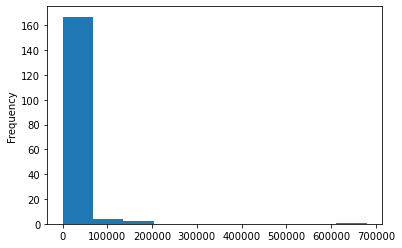

In [11]:
#Creating readme_length column
df_copy['readme_length'] = df_copy.readme_contents_cleaned.apply(len)

df_copy.groupby('language_cleaned').readme_length.mean()

df_copy.readme_length.plot.hist()

In [12]:
#Making word count column
df_copy['word_count'] = df_copy.readme_contents_cleaned.apply(str.split).apply(len)

Text(0.5, 1.0, 'read length vs word count')

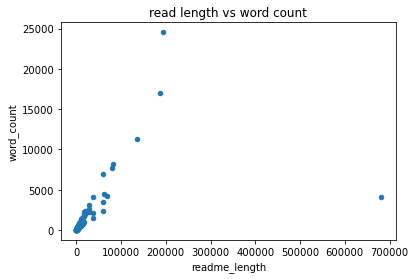

In [13]:
#Plotting readme_length vs word count
df_copy.plot.scatter(y='word_count', x='readme_length')
plt.title('read length vs word count')

In [14]:
#Verify new columns were added
df_copy.head()

,repo_name_cleaned,language_cleaned,readme_contents_cleaned,readme_length,word_count
0,irisshadersiris,java,iris opensource shaders mod compatible optifine shaderpacksdocsbannerpng iris link vis...,6573,842
1,returntocorpsemgrep,java,br p aligncenter hrefhttpssemgrepdevimg srchttpsrawgithubusercontentcomreturntocorpsem...,5960,528
2,caffeinemcsodiumfabric,java,img srcsrcmainresourcesassetssodiumiconpng width128 sodium fabric github licensehttpsi...,4891,493
3,keycloakkeycloak,java,keycloak keycloak open source identity access management solution modern application s...,1910,170
4,nationalsecurityagencyghidra,java,img srcghidrafeaturesbasesrcmainresourcesimagesghidra_3png width400 ghidra software re...,3757,413


In [15]:
#Looking to value counts of each category
df_copy.language_cleaned.value_counts()

javascript    47
python        47
java          42
r             38
Name: language_cleaned, dtype: int64

# Exploration

#### Split into train, validate, and test after creating new features

In [16]:
# splitting into train, validate, test
train, validate, test= explore.lang_split(df_copy)

In [17]:
# Looking at shape
train.shape, validate.shape, test.shape

((97, 5), (42, 5), (35, 5))

In [18]:
# Looking at values
train.head()

,repo_name_cleaned,language_cleaned,readme_contents_cleaned,readme_length,word_count
8,opensearchprojectopensearch,java,img srchttpsopensearchorgassetsbrandsvglogoopensearch_logo_defaultsvg height64px welco...,1350,94
196,rspatialmapview,r,output github_document r setup include false knitropts_chunkset collapse true eval fal...,3869,297
95,mlrorgmlr3misc,r,mlr3misc package website releasehttpsmlr3miscmlrorgcom devhttpsmlr3miscmlrorgcomdev mi...,541,18
9,sqshqpiggymetrics,java,build statushttpstravisciorgsqshqpiggymetricssvgbranchmasterhttpstravisciorgsqshqpiggy...,17081,1735
60,atomatom,javascript,atom build statushttpsdevazurecomgithubatom_apisbuildstatusatom20production20branchesb...,3238,275


In [19]:
#creating strings for content
javascript_content = ' '.join(train[train.language_cleaned == 'javascript'].readme_contents_cleaned)
python_content = ' '.join(train[train.language_cleaned == 'python'].readme_contents_cleaned)
java_content = ' '.join(train[train.language_cleaned == 'java'].readme_contents_cleaned)
r_content = ' '.join(train[train.language_cleaned == 'r'].readme_contents_cleaned)
all_content = ' '.join(train.readme_contents_cleaned)

In [20]:
#verify contents were changes to string
type(javascript_content)

str

In [21]:
#Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how 
# often each of the words occurs.
javascript_content_freq = pd.Series(javascript_content.split()).value_counts()
python_content_freq = pd.Series(python_content.split()).value_counts()
java_content_freq = pd.Series(java_content.split()).value_counts()
r_content_freq = pd.Series(r_content.split()).value_counts()
all_content_freq = pd.Series(all_content.split()).value_counts()

In [22]:
javascript_content_freq.head(20)

ul                  1065
icon                 432
freewarefreeware     395
li                   357
data                 344
const                338
target_blankimg      337
worldwide            301
use                  300
instance             274
function             273
softwareoss          263
1                    257
opensource           235
bad                  207
javascript           205
good                 202
h4                   200
one                  180
aws                  164
dtype: int64

In [23]:
python_content_freq.head(20)

yes           1013
unknown        626
data           429
api            414
learning       385
apikey         341
machine        333
video          291
library        290
python         270
use            219
using          193
file           191
model          179
format         171
deprecated     167
open           165
code           149
language       143
network        136
dtype: int64

In [24]:
java_content_freq.head(20)

use            84
service        69
build          66
project        64
java           56
&#9;           54
support        51
code           45
dependency     43
p              43
system         40
see            40
application    38
img            38
using          37
iris           37
version        36
run            36
user           35
spring         34
dtype: int64

In [25]:
r_content_freq.head(20)

r            170
data          99
model         80
package       73
use           54
function      45
install       43
using         35
book          34
version       34
time          34
example       32
type          29
course        28
file          27
run           25
please        25
series        25
code          23
modeltime     22
dtype: int64

In [26]:
all_content_freq.head(20)

ul                  1065
yes                 1022
data                 897
use                  657
unknown              629
api                  490
icon                 437
using                425
learning             398
freewarefreeware     395
1                    394
function             375
machine              362
li                   359
file                 350
apikey               342
target_blankimg      340
library              340
const                338
code                 315
dtype: int64

In [27]:
#concating all frequency columns into a dataframe
word_counts = pd.concat([javascript_content_freq, python_content_freq, java_content_freq, r_content_freq, all_content_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['javascript_freq', 'python_freq', 'java_freq', 'r_freq', 'all_content_freq' ]

In [38]:
#Looking at values of word counts
word_counts

,javascript_freq,python_freq,java_freq,r_freq,all_content_freq
ul,1065,0,0,0,1065
icon,432,5,0,0,437
freewarefreeware,395,0,0,0,395
li,357,2,0,0,359
data,344,429,25,99,897
...,...,...,...,...,...
solar,0,0,0,1,1
1group,0,0,0,1,1
differing,0,0,0,1,1
complexheatmaphttpsjokergoogithubio20200515interactivecomplexheatmap,0,0,0,1,1


Text(0.5, 1.0, 'Javascript vs Java count for the top 20 most frequent words')

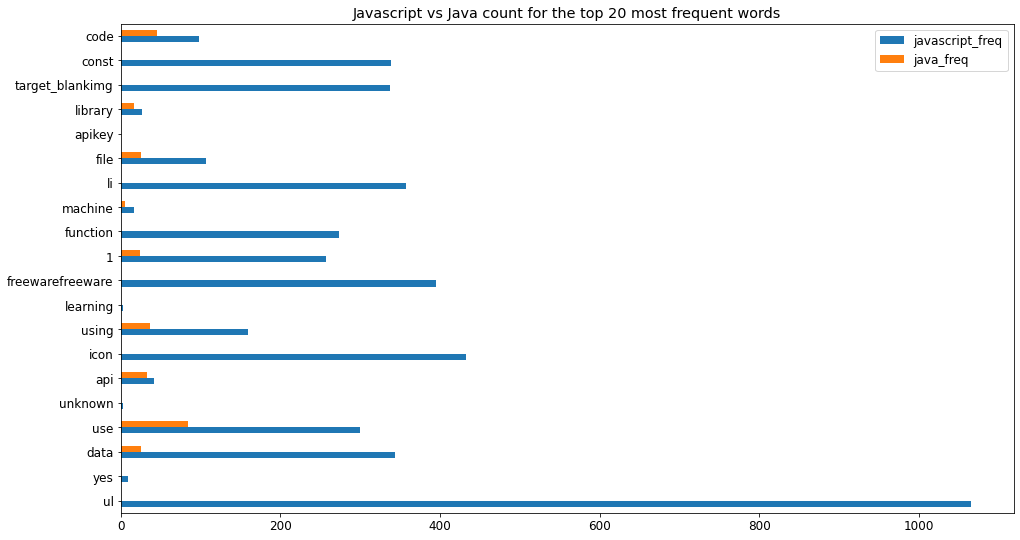

In [41]:
#plotting javascript freq words vs java frequent words
plt.rc('font', size=12)
plt.rc('figure', figsize=(16,9))
word_counts.sort_values('all_content_freq', ascending=False).head(20)[['javascript_freq', 'java_freq']].plot.barh()
plt.title('Javascript vs Java count for the top 20 most frequent words')


In [39]:
word_counts.keys()

Index(['javascript_freq', 'python_freq', 'java_freq', 'r_freq',
       'all_content_freq'],
      dtype='object')

Text(0.5, 1.0, 'Javascript vs Python count for the top 20 most frequent words')

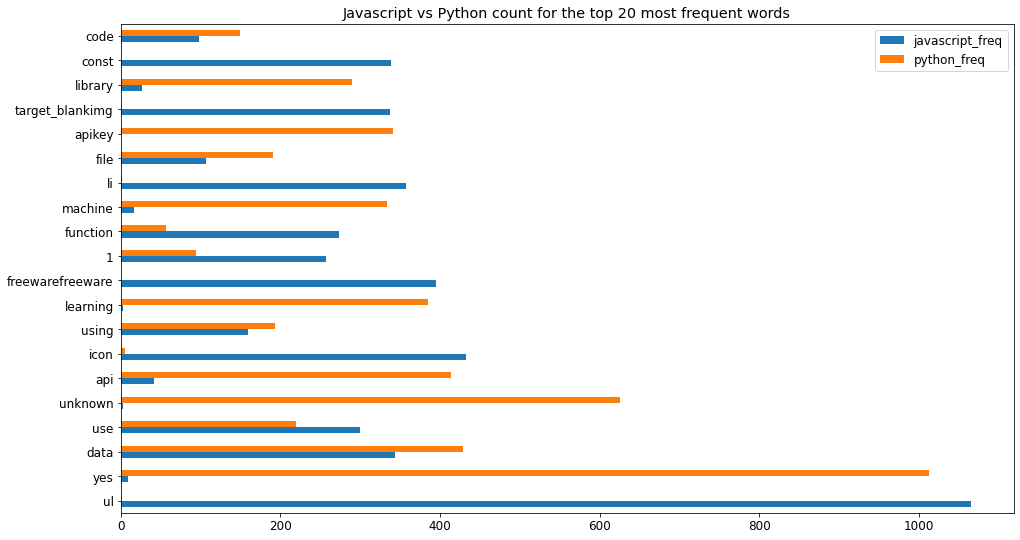

In [47]:
#plotting javascript freq words vs python frequent words
plt.rc('font', size=12)
plt.rc('figure', figsize=(16,9))
word_counts.sort_values('all_content_freq', ascending=False).head(20)[['javascript_freq', 'python_freq']].plot.barh()
plt.title('Javascript vs Python count for the top 20 most frequent words')

Text(0.5, 1.0, 'Javascript vs R count for the top 20 most frequent words')

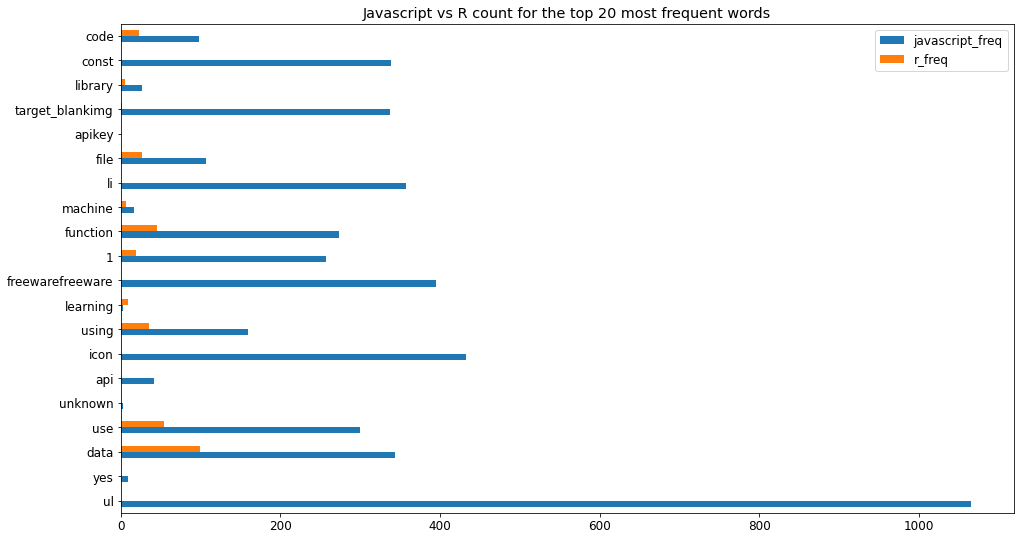

In [48]:
#plotting javascript freq words vs r frequent words
plt.rc('font', size=12)
plt.rc('figure', figsize=(16,9))
word_counts.sort_values('all_content_freq', ascending=False).head(20)[['javascript_freq', 'r_freq']].plot.barh()
plt.title('Javascript vs R count for the top 20 most frequent words')

Text(0.5, 1.0, 'Python vs R count for the top 20 most frequent words')

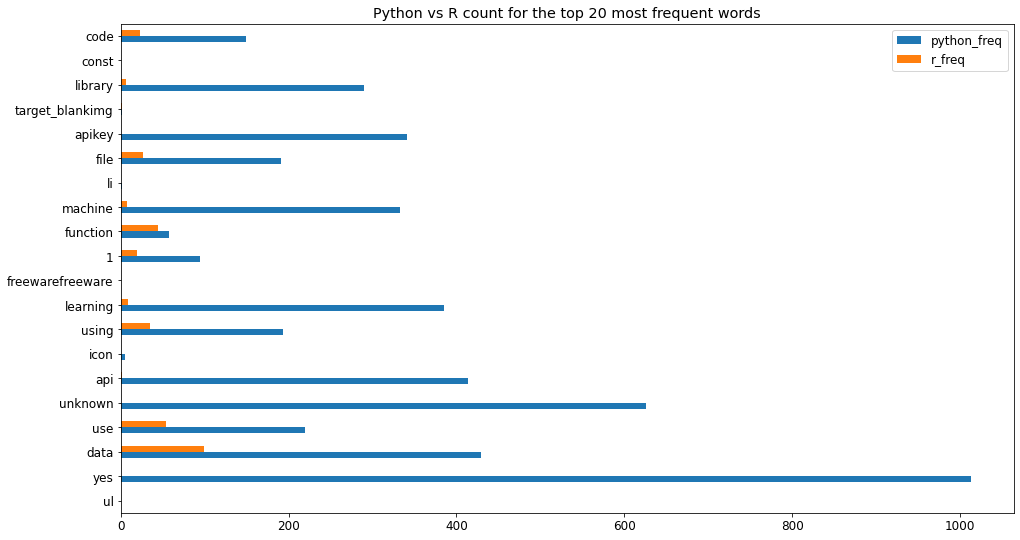

In [30]:
#plotting python freq words vs r frequent words
plt.rc('font', size=12)
plt.rc('figure', figsize=(16,9))
word_counts.sort_values('all_content_freq', ascending=False).head(20)[['python_freq', 'r_freq']].plot.barh()
plt.title('Python vs R count for the top 20 most frequent words')

Text(0.5, 1.0, 'Python vs Java count for the top 20 most frequent words')

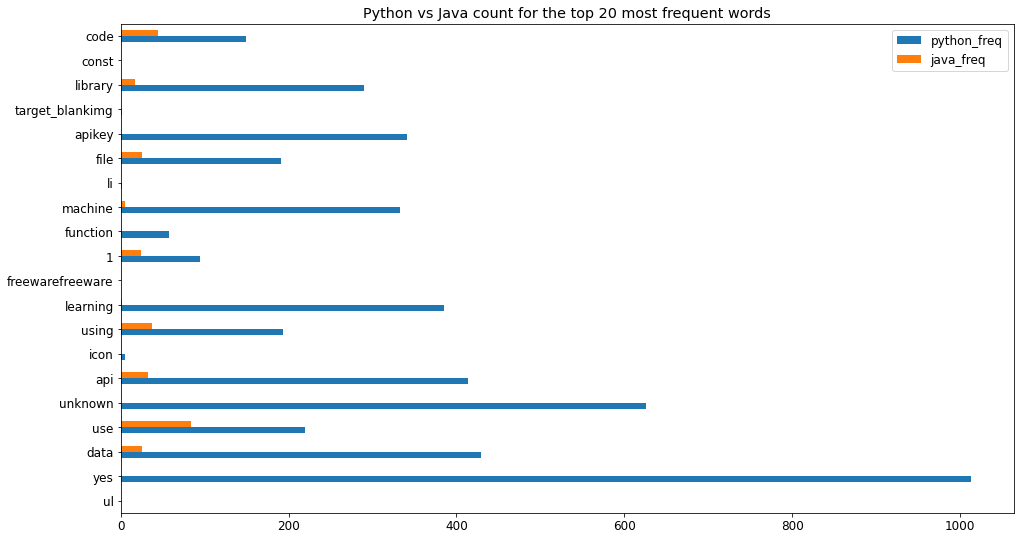

In [49]:
#plotting python freq words vs Java frequent words
plt.rc('font', size=12)
plt.rc('figure', figsize=(16,9))
word_counts.sort_values('all_content_freq', ascending=False).head(20)[['python_freq', 'java_freq']].plot.barh()
plt.title('Python vs Java count for the top 20 most frequent words')

Text(0.5, 1.0, 'R vs Java count for the top 20 most frequent words')

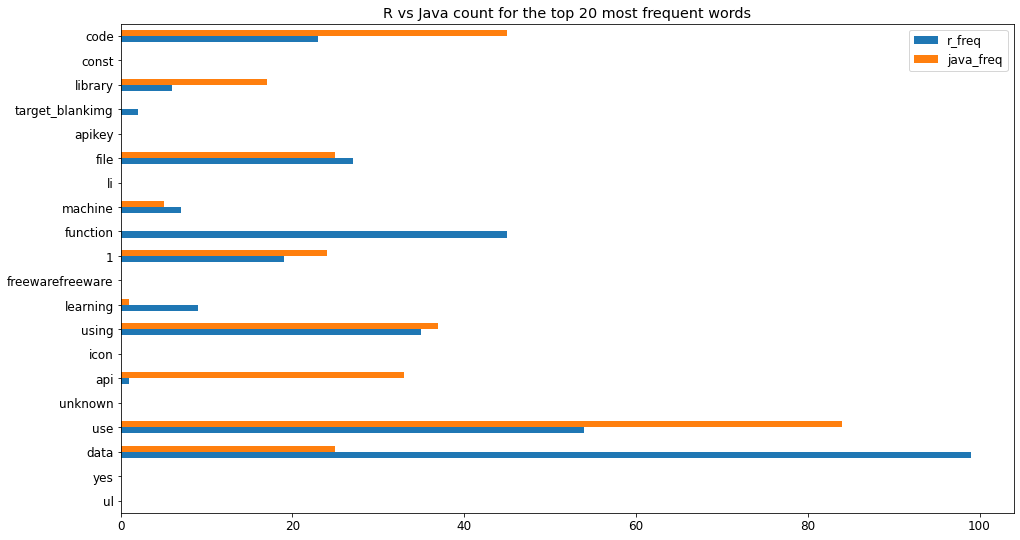

In [51]:
#plotting r freq words vs java frequent words
plt.rc('font', size=12)
plt.rc('figure', figsize=(16,9))
word_counts.sort_values('all_content_freq', ascending=False).head(20)[['r_freq', 'java_freq']].plot.barh()
plt.title('R vs Java count for the top 20 most frequent words')

**Word overlap by language**

In [68]:
javascript_overlap= (word_counts.sort_values(by='all_content_freq', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all_content_freq'], axis=1)
 .drop(columns='all_content_freq')
 .sort_values(by='javascript_freq', ascending = False))

In [69]:
type(javascript_overlap)

pandas.core.frame.DataFrame

In [70]:
javascript_overlap

,javascript_freq,python_freq,java_freq,r_freq
ul,1.000000,0.000000,0.000000,0.000000
freewarefreeware,1.000000,0.000000,0.000000,0.000000
const,1.000000,0.000000,0.000000,0.000000
li,0.994429,0.005571,0.000000,0.000000
target_blankimg,0.991176,0.002941,0.000000,0.005882
icon,0.988558,0.011442,0.000000,0.000000
function,0.728000,0.152000,0.000000,0.120000
1,0.652284,0.238579,0.060914,0.048223
use,0.456621,0.333333,0.127854,0.082192
data,0.383501,0.478261,0.027871,0.110368


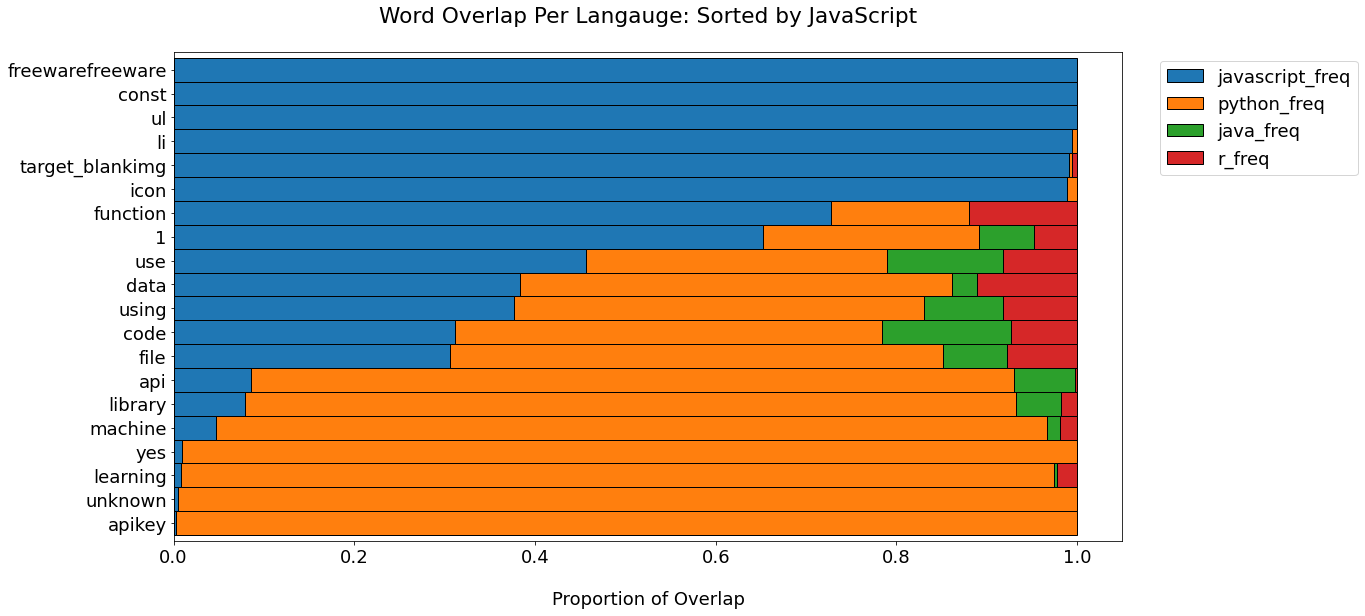

In [44]:
plt.rc('font', size=18)
(word_counts.sort_values(by='all_content_freq', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all_content_freq'], axis=1)
 .drop(columns='all_content_freq')
 .sort_values(by='javascript_freq')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by JavaScript\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

In [67]:
(word_counts.sort_values(by='all_content_freq', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all_content_freq'], axis=1)
 .drop(columns='all_content_freq')
 .sort_values(by='python_freq', ascending= False))

,javascript_freq,python_freq,java_freq,r_freq
apikey,0.002924,0.997076,0.000000,0.000000
unknown,0.004769,0.995231,0.000000,0.000000
yes,0.008806,0.991194,0.000000,0.000000
learning,0.007538,0.967337,0.002513,0.022613
machine,0.046961,0.919890,0.013812,0.019337
library,0.079412,0.852941,0.050000,0.017647
api,0.085714,0.844898,0.067347,0.002041
file,0.305714,0.545714,0.071429,0.077143
data,0.383501,0.478261,0.027871,0.110368
code,0.311111,0.473016,0.142857,0.073016


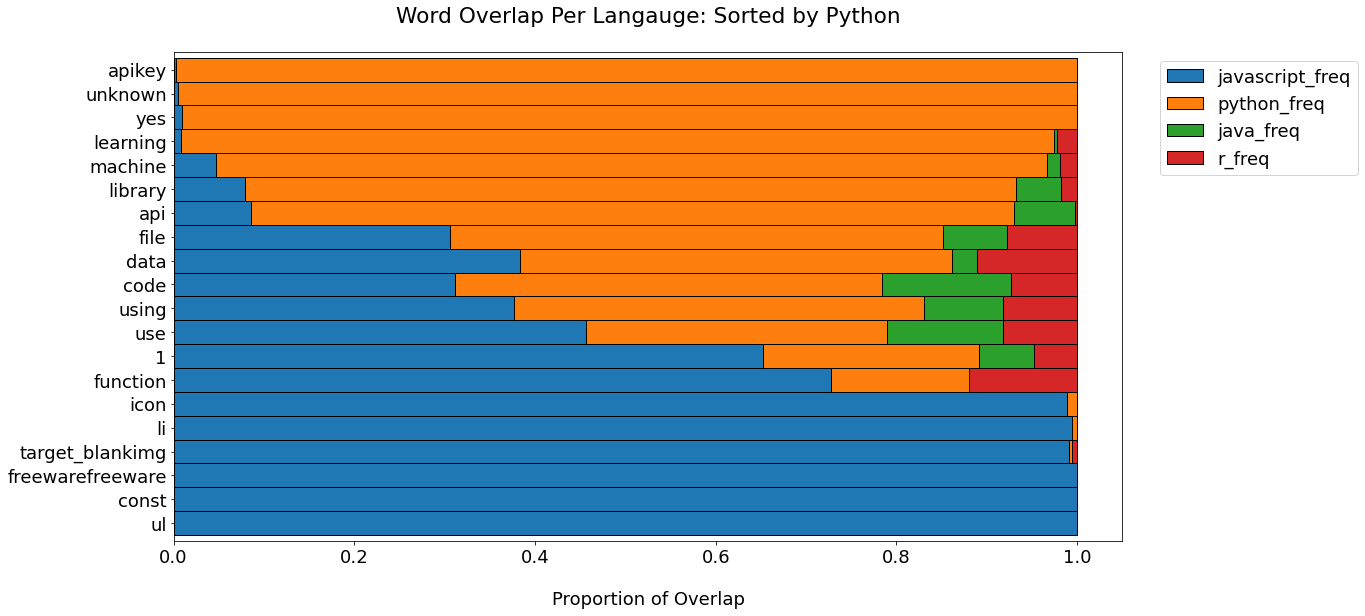

In [49]:
## proportion stacked bar charts sorted by Python

plt.rc('font', size=18)
(word_counts.sort_values(by='all_content_freq', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all_content_freq'], axis=1)
 .drop(columns='all_content_freq')
 .sort_values(by='python_freq')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by Python\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

In [75]:
#Java most frequent words
(word_counts.sort_values(by='all_content_freq', ascending=False)
 .head(50)
 .apply(lambda row: row / row['all_content_freq'], axis=1)
 .drop(columns='all_content_freq')
 .sort_values(by='java_freq', ascending= False))

,javascript_freq,python_freq,java_freq,r_freq
project,0.216346,0.423077,0.307692,0.052885
&#9;,0.736585,0.000000,0.263415,0.000000
service,0.561069,0.175573,0.263359,0.000000
support,0.274038,0.451923,0.245192,0.028846
img,0.398058,0.373786,0.184466,0.043689
run,0.401914,0.306220,0.172249,0.119617
version,0.238494,0.468619,0.150628,0.142259
code,0.311111,0.473016,0.142857,0.073016
use,0.456621,0.333333,0.127854,0.082192
time,0.407080,0.318584,0.123894,0.150442


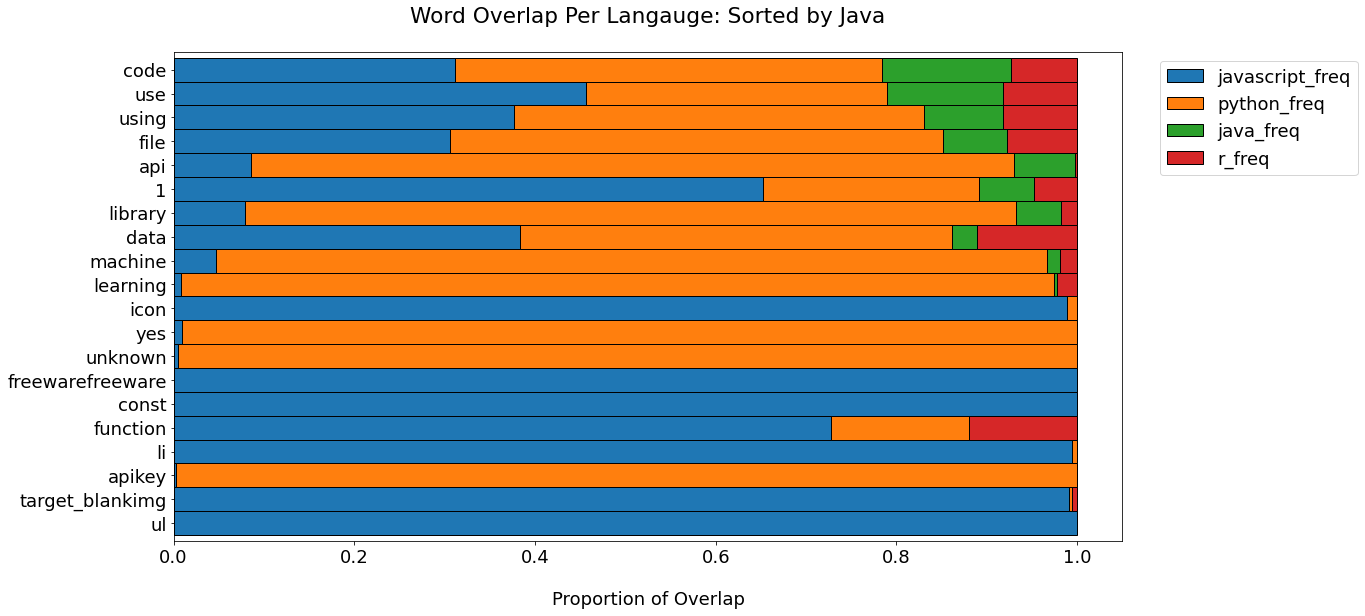

In [50]:
plt.rc('font', size=18)
(word_counts.sort_values(by='all_content_freq', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all_content_freq'], axis=1)
 .drop(columns='all_content_freq')
 .sort_values(by='java_freq')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by Java\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

## Bigrams

In [98]:
javascript_words= re.sub(r'[^\w\s]', '', javascript_content).split()

In [99]:
javascript_only= ' '. join(javascript_words)

In [100]:
js_bigrams= (pd.Series(nltk.ngrams(javascript_words,2))
          .value_counts()
          .head(10))

In [101]:
js_bigrams

(freewarefreeware, icon)     364
(ul, li)                     294
(opensource, softwareoss)    234
(javascript, bad)            111
(li, ul)                      93
(ul, h4)                      75
(app, storeappstore)          68
(bad, const)                  64
(good, const)                 59
(ul, h3)                      52
dtype: int64

### Bags of words

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
bag_of_words = cv.fit_transform(train.readme_contents_cleaned)
bag_of_words

<97x26792 sparse matrix of type '<class 'numpy.int64'>'
	with 45407 stored elements in Compressed Sparse Row format>

In [32]:
#Put bag of words into a dataframe
pd.DataFrame(bag_of_words.todense(), columns=cv.get_feature_names())

,0001,00025,00042,007f7f,01,010x,0120,015,0150,016666667,...,zparhttpsgithubcomfrcchangzpar,zsh,zshhttpswwwzshorg,zsrcalgorithmsstringzalgorithm,zubehttpszubeiodocsapi,zuguang,zulfikarbsubabr,zulip,zuul,zxvf
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(2,2))
X_data = tfidf.fit_transform(df_copy.readme_contents_cleaned)
y_data = df.language_cleaned

# #insert X_validate, and y_validate
# X_train_validate, X_test, y_train_validate, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=12, stratify = y_data)
# X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=.2, random_state=12, stratify= y_train_validate)

# #split x, y train
# #stratify on y_data

In [106]:
X_train, X_validate, y_train, y_validate, X_test, y_test = explore.xy_split(X_data, y_data)

## Bag Of Ngrams

In [107]:
# cv = CountVectorizer(ngram_range=(2, 2))
# bag_of_words = cv.fit_transform(train.readme_contents_cleaned)

In [108]:
# pprint(train.readme.contents_cleaned)
# pd.DataFrame(bag_of_words.todense(), columns=cv.get_feature_names())

# Model and Evaluate

## Baseline Model

In [109]:
#Look at most common language to set baseline to
y_train.value_counts()

javascript    30
python        30
java          27
r             24
Name: language_cleaned, dtype: int64

In [110]:
#Creating baseline column
train['baseline']= 'javascript'

In [111]:
#looking at values
train.head()

,repo_name_cleaned,language_cleaned,readme_contents_cleaned,readme_length,word_count,baseline
8,opensearchprojectopensearch,java,img srchttpsopensearchorgassetsbrandsvglogoopensearch_logo_defaultsvg height64px welco...,1350,94,javascript
196,rspatialmapview,r,output github_document r setup include false knitropts_chunkset collapse true eval fal...,3869,297,javascript
95,mlrorgmlr3misc,r,mlr3misc package website releasehttpsmlr3miscmlrorgcom devhttpsmlr3miscmlrorgcomdev mi...,541,18,javascript
9,sqshqpiggymetrics,java,build statushttpstravisciorgsqshqpiggymetricssvgbranchmasterhttpstravisciorgsqshqpiggy...,17081,1735,javascript
60,atomatom,javascript,atom build statushttpsdevazurecomgithubatom_apisbuildstatusatom20production20branchesb...,3238,275,javascript


In [112]:
# 1. Create the object
baseline = DummyClassifier(strategy='constant', constant= "javascript")
# 2. Fit the object
baseline.fit(X_train, y_train)
# how does it do on training data set?
print('Baseline accuracy: %.4f' % baseline.score(X_train, y_train))

Baseline accuracy: 0.2703


## Decision Tree Model

In [113]:
#Create the object
tree = DecisionTreeClassifier(max_depth=5)
#Fit it
tree.fit(X_train, y_train)

#Creating prediction for y_train
#set train to a new dataframe with actual column set as y_train (actual values)
train = pd.DataFrame(dict(actual=y_train))
#Add prediction column to new train a dataframe using .predict function and X_train (predicted values)
train['predicted'] = tree.predict(X_train)

#Get accuracy score: the % of times our model predicted correctly
print(f'train score: {tree.score(X_train, y_train):.2%}')
print(f'validate score: {tree.score(X_validate, y_validate):.2%}')

train score: 64.86%
validate score: 53.57%


In [114]:
train.head()

,actual,predicted
120,java,java
147,python,java
55,javascript,javascript
127,python,java
131,python,java


In [115]:
#Sanity check
train.head()

,actual,predicted
120,java,java
147,python,java
55,javascript,javascript
127,python,java
131,python,java


In [116]:
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Confusion Matrix
actual      java  javascript  python   r
predicted                               
java          27          19      13   7
javascript     0          11       0   0
python         0           0      17   0
r              0           0       0  17
---
              precision    recall  f1-score   support

        java       0.41      1.00      0.58        27
  javascript       1.00      0.37      0.54        30
      python       1.00      0.57      0.72        30
           r       1.00      0.71      0.83        24

    accuracy                           0.65       111
   macro avg       0.85      0.66      0.67       111
weighted avg       0.86      0.65      0.66       111



### Decision Tree model with countvectorizer

In [123]:
# cv = CountVectorizer()
# X = cv.fit_transform(df_copy.readme_contents_cleaned)
# y = df.language_cleaned

# tree = DecisionTreeClassifier(max_depth=5)
# tree.fit(X_train, y_train)

# tree.score(X_train, y_train)

In [119]:
# tree.score(X_validate, y_validate)

- Note: This model very overfit to the train, although very high training score

## Random Forest Model

In [120]:
#Create the object
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
# Fit it
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [121]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.58


In [122]:
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on validate set: 0.25


- Note: Highest training score but still very overfit